# This notebook is modified from kaggle notebook wrote by Leonardo Ferreira 
https://www.kaggle.com/kabure/eda-feat-engineering-encode-conquer

# Competition description:
Is there a cat in your dat?

A common task in machine learning pipelines is encoding categorical variables for a given algorithm in a format that allows as much useful signal as possible to be captured.

Because this is such a common task and important skill to master, we've put together a dataset that contains only categorical features, and includes:

- binary features
- low- and high-cardinality nominal features
- low- and high-cardinality ordinal features
- (potentially) cyclical features

# Objective:
understand how to

- observe the data
- handle missing data
- encode categorical feature

## Import Library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
# Any results you write to the current directory are saved as output.

import gc

## Some utilities functions 

In [2]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['% of missing values'] = df.isnull().sum().values * 100 / df.shape[0]   
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def ploting_cat_fet(df, cols, vis_row=5, vis_col=2):
    
    grid = gridspec.GridSpec(vis_row,vis_col) # The grid of chart
    plt.figure(figsize=(17, 35)) # size of figure

    # loop to get column and the count of plots
    for n, col in enumerate(df[cols]): 
        tmp = pd.crosstab(df[col], df['target'], normalize='index') * 100
        tmp = tmp.reset_index()
        tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

        ax = plt.subplot(grid[n]) # feeding the figure of grid
        sns.countplot(x=col, data=df, order=list(tmp[col].values) , color='green') 
        ax.set_ylabel('Count', fontsize=15) # y axis label
        ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
        ax.set_xlabel(f'{col} values', fontsize=15) # x axis label

        # twinX - to build a second yaxis
        gt = ax.twinx()
        gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
        gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
        gt.set_ylabel("Target %True(1)", fontsize=16)
        sizes=[] # Get highest values in y
        for p in ax.patches: # loop to all objects
            height = p.get_height()
            sizes.append(height)
            ax.text(p.get_x()+p.get_width()/2.,
                    height + 3,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center", fontsize=14) 
        ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights


    plt.subplots_adjust(hspace = 0.5, wspace=.3)
    plt.show()

<div style="background-color:lightblue;">
    <center>
        <h3 style="color:red; font-size:24px; font-family:Segoe Print;">Knowing our data</h3>
    </center>
</div>

In [4]:
df = pd.read_csv('train.csv')

In [5]:
summary = resumetable(df)
summary

Dataset Shape: (600000, 25)


,Name,dtypes,% of missing values,Uniques,First Value,Second Value
0,id,int64,0.000000,600000,0,1
1,bin_0,float64,2.982333,2,0,1
2,bin_1,float64,3.000500,2,0,1
3,bin_2,float64,2.988333,2,0,0
4,bin_3,object,3.002333,2,F,F
5,bin_4,object,3.007833,2,N,Y
6,nom_0,object,3.042000,3,Red,Red
7,nom_1,object,3.026000,6,Trapezoid,Star
8,nom_2,object,3.005833,6,Hamster,Axolotl
9,nom_3,object,3.020167,6,Russia,NaN


<h1><font color='blue'> Handling missing value</font></h1>

### approach 1 : drop missing value 
### (recommend for large dataset or row (col) that have too many missing value)

In [6]:
print('Original: {}'.format(df.shape))

# drop rows with missing values
df_drop_row = df.dropna()
print('Drop row all: {}'.format(df_drop_row.shape))

# drop columns with missing values
df_drop_col = df.dropna(axis=1)
print('Drop column: {}'.format(df_drop_col.shape))

# keep rows that have at least 14 non-NaN values
df_drop_row_thresh = df.dropna(thresh=23)
print('Drop row 14: {}'.format(df_drop_row_thresh.shape))

# only drop rows where NaN appear in specific columns (here: 'nom_1')
df_drop_row_occupation = df.dropna(subset=['nom_1'])
print('Drop row nom_1: {}'.format(df_drop_row_occupation.shape))

Original: (600000, 25)
Drop row all: (298042, 25)
Drop column: (600000, 2)
Drop row 14: (581536, 25)
Drop row nom_1: (581844, 25)


### approach 2 : impute missing value (recommend for small dataset)

In [7]:
from sklearn.impute import SimpleImputer

In [8]:
%%time
imr = SimpleImputer(missing_values = np.NaN, strategy = 'most_frequent')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)

df_impute = pd.DataFrame(imputed_data)
df_impute.columns = df.columns

display(df.head())
display(df_impute.head())

# check if there are still missing values
display(df_impute.isnull().sum())

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,...,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,...,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,F,N,Red,Trapezoid,Hamster,Russia,...,02e7c8990,3,Contributor,Hot,c,U,Pw,6,3,0
1,1,1,1,0,F,Y,Red,Star,Axolotl,India,...,f37df64af,3,Grandmaster,Warm,e,X,pE,7,7,0
2,2,0,1,0,F,N,Red,Triangle,Hamster,Canada,...,8f3276a6e,3,Novice,Freezing,n,P,eN,5,9,0
3,3,0,0,0,F,N,Red,Circle,Hamster,Finland,...,f9d456e57,1,Novice,Lava Hot,a,C,Fl,3,3,0
4,4,0,0,0,T,N,Red,Triangle,Hamster,Costa Rica,...,c5361037c,3,Grandmaster,Cold,h,C,OZ,5,12,0


id        0
bin_0     0
bin_1     0
bin_2     0
bin_3     0
bin_4     0
nom_0     0
nom_1     0
nom_2     0
nom_3     0
nom_4     0
nom_5     0
nom_6     0
nom_7     0
nom_8     0
nom_9     0
ord_0     0
ord_1     0
ord_2     0
ord_3     0
ord_4     0
ord_5     0
day       0
month     0
target    0
dtype: int64

CPU times: user 9min 5s, sys: 463 ms, total: 9min 6s
Wall time: 9min 6s


In [9]:
df = df_impute.copy()

<h1><font color='blue'> Target Features</font></h1>

- Let's see the distribution and if we can identify what is the nature of this feature

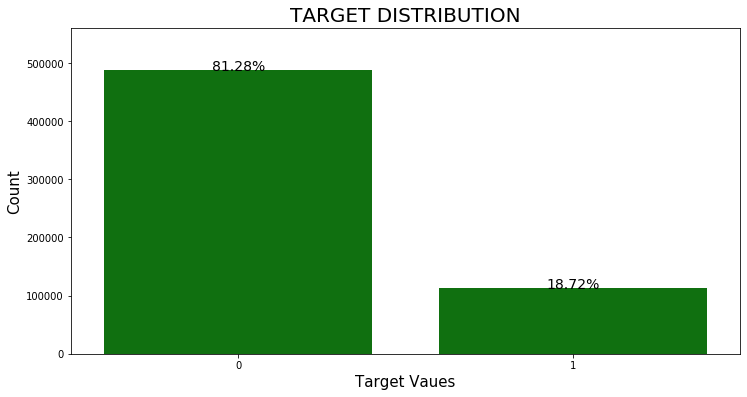

In [10]:
total = len(df)
plt.figure(figsize=(12,6))

g = sns.countplot(x='target', data=df, color='green')
g.set_title("TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Vaues", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
sizes=[] # Get highest values in y
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

<div style="background-color:lightblue;">
    <center>
        <h3 style="color:red; font-size:24px; font-family:Segoe Print;">EDA & Encoding</h3>
    </center>
</div>

<h1><font color='blue'> Binary Features</font></h1>

In [11]:
bin_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

### Features before transformation

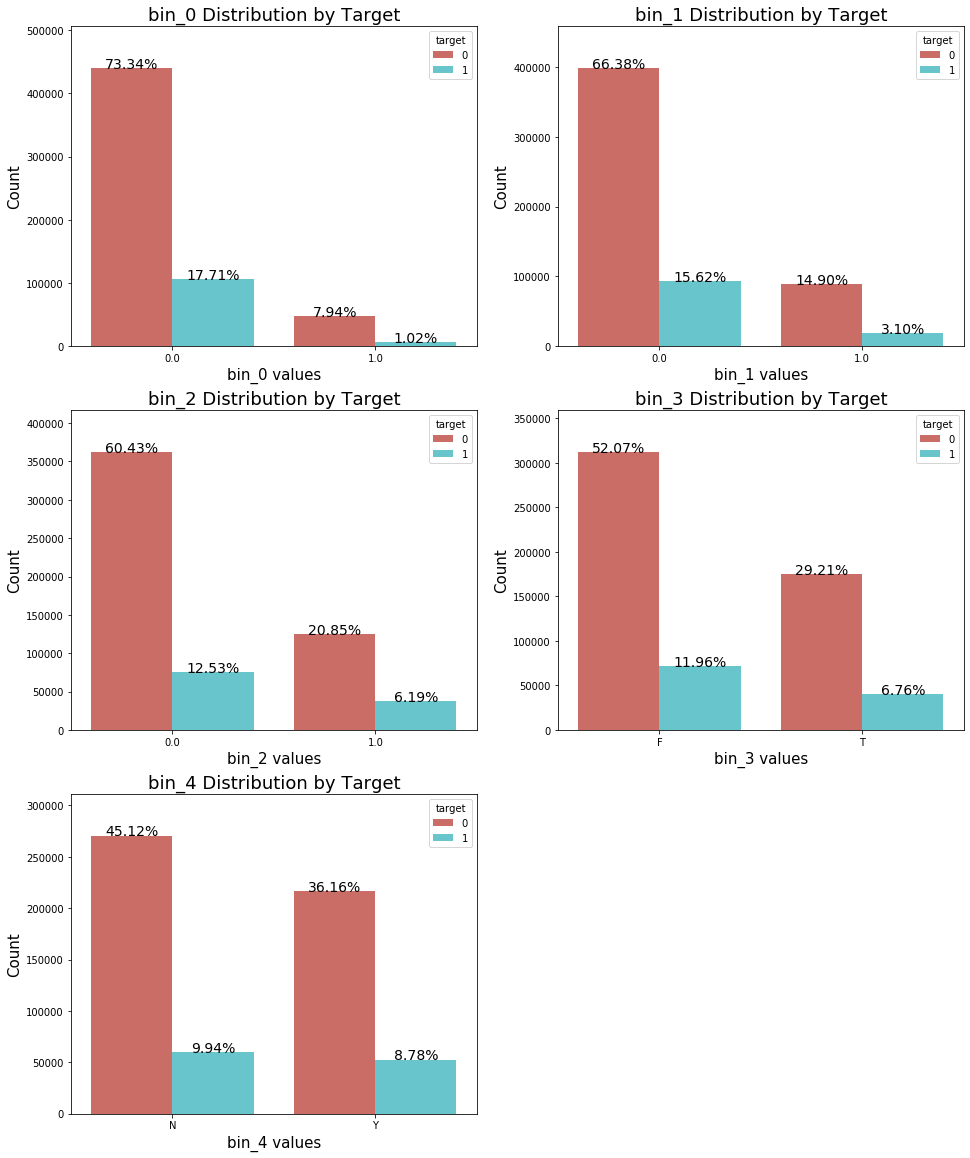

In [12]:
#Looking the V's features
import matplotlib.gridspec as gridspec # to do the grid of plots
grid = gridspec.GridSpec(3, 2) # The grid of chart
plt.figure(figsize=(16,20)) # size of figure

# loop to get column and the count of plots
for n, col in enumerate(df[bin_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=df, hue='target', palette='hls') 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label
    sizes=[] # Get highest values in y
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 
    ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights
    
plt.show()

### Features Transformation
I'm assuming that: 
- T is True and F is False
- Y is Yes and N is No

In [13]:
# dictionary to map the feature
bin_dict = {'T':1, 'F':0, 'Y':1, 'N':0}

# Maping the category values in our dict
df['bin_3'] = df['bin_3'].map(bin_dict)
df['bin_4'] = df['bin_4'].map(bin_dict)

### Checking the results

In [14]:
df[['bin_3', 'bin_4']].head()

,bin_3,bin_4
0,0,0
1,0,1
2,0,0
3,0,0
4,1,0


<h1><font color='blue'> Nominal Features</font></h1>

## Low Cardinality Nominal Features (with more than 2 and less than 15 values)

In [15]:
nom_cols = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']

### Features before transformation

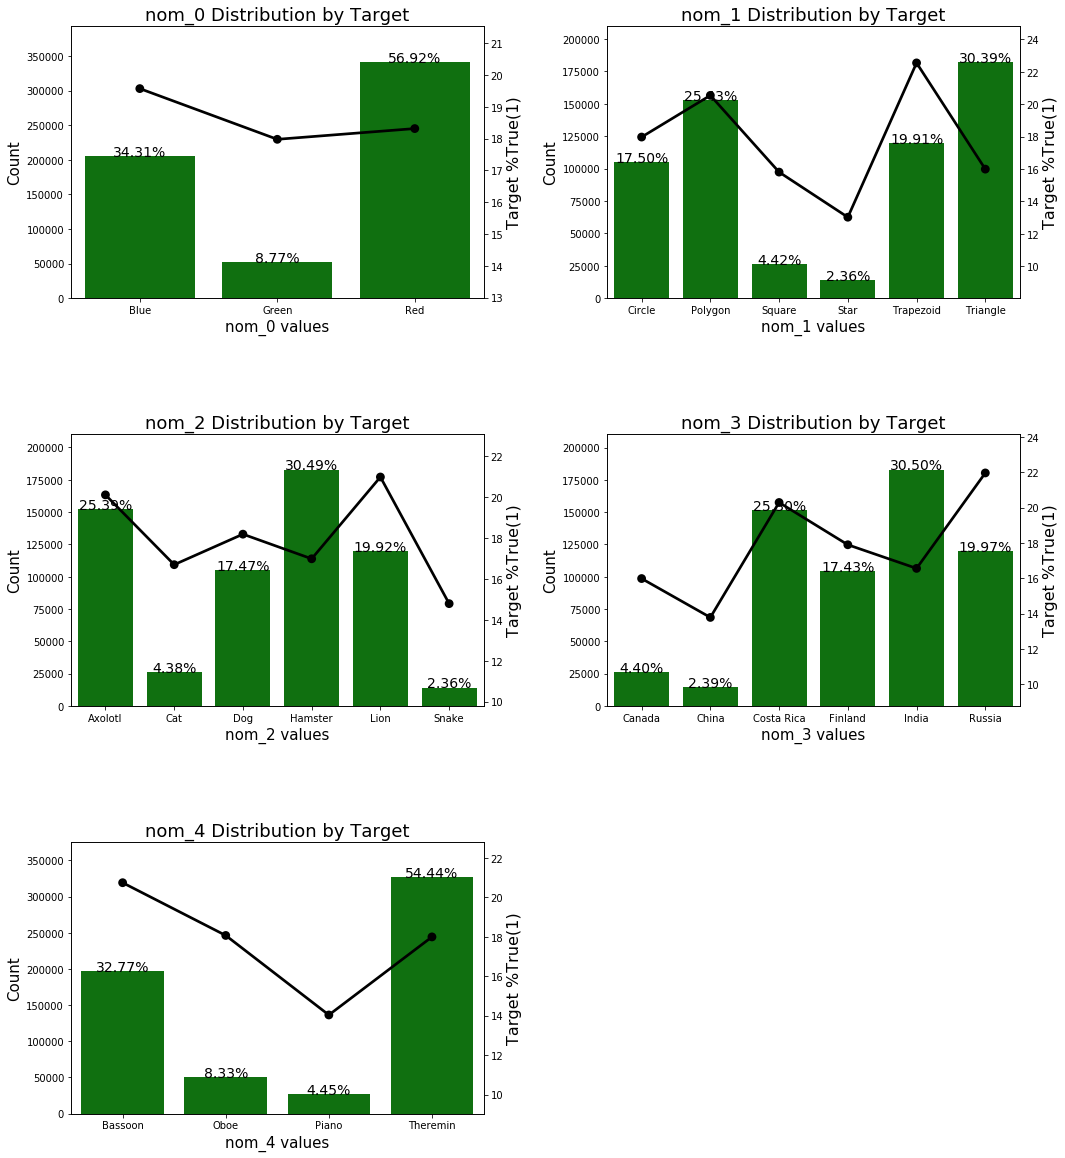

In [16]:
ploting_cat_fet(df, nom_cols, vis_row=5, vis_col=2)

### Features Transformation (one-hot encoding)

In [17]:
print(f'Shape before dummy transformation: {df.shape}')
df = pd.get_dummies(df, columns=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'],\
                          prefix=['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4'], drop_first=True)
print(f'Shape after dummy transformation: {df.shape}')

Shape before dummy transformation: (600000, 25)
Shape after dummy transformation: (600000, 40)


### Checking the results

In [18]:
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,...,nom_2_Lion,nom_2_Snake,nom_3_China,nom_3_Costa Rica,nom_3_Finland,nom_3_India,nom_3_Russia,nom_4_Oboe,nom_4_Piano,nom_4_Theremin
0,0,0,0,0,0,0,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,...,0,0,0,0,0,0,1,0,0,0
1,1,1,1,0,0,1,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,...,0,0,0,0,0,1,0,0,0,1
2,2,0,1,0,0,0,b574c9841,708248125,5ddc9a726,745b909d1,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,...,0,0,0,0,1,0,0,0,0,1
4,4,0,0,0,1,0,777d1ac2c,3a7975e46,bc9cc2a94,7d7c02c57,...,0,0,0,1,0,0,0,0,0,1


In [55]:
demo['nom_3'].unique()

array(['Russia', 'Costa Rica', 'Finland', 'India', 'Canada', 'China'],
      dtype=object)

## High Cardinality Nominal Features

In [19]:
high_card_feats = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

### Features before transformation

In [20]:
resumetable(df[high_card_feats])

Dataset Shape: (600000, 5)


,Name,dtypes,% of missing values,Uniques,First Value,Second Value
0,nom_5,object,0.0,1220,de4c57ee2,2bb3c3e5c
1,nom_6,object,0.0,1519,a64bc7ddf,3a3a936e8
2,nom_7,object,0.0,222,598080a91,1dddb8473
3,nom_8,object,0.0,222,0256c7a4b,52ead350c
4,nom_9,object,0.0,2218,02e7c8990,f37df64af


### Features Transformation (frequncy encoding)

In [21]:
for col in high_card_feats:
    enc_nom_1 = (df.groupby(col).size()) / len(df)
    df[f'freq_{col}'] = df[col].apply(lambda x : enc_nom_1[x])

### Checking the results

In [22]:
df['freq_nom_5'].head()

0    0.000683
1    0.001230
2    0.001195
3    0.000997
4    0.001373
Name: freq_nom_5, dtype: float64

<h1><font color='blue'> Ordinal Features</font></h1>

## Low Cardinality Ordinal Features

In [23]:
ord_cols = ['ord_0', 'ord_1', 'ord_2', 'ord_3']

### Features before transformation

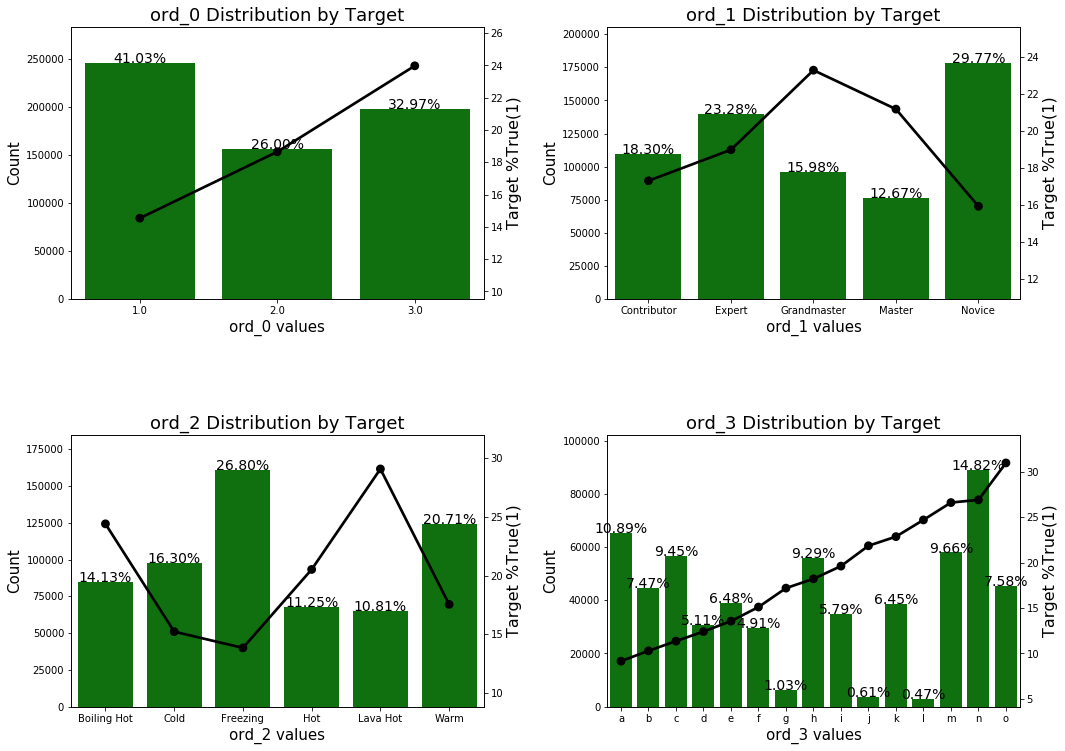

In [24]:
ploting_cat_fet(df, ord_cols, vis_row=5, vis_col=2)

## Ord_4 and ord_5

In [25]:
df['ord_5_ot'] = 'Others'
df.loc[df['ord_5'].isin(df['ord_5'].value_counts()[:25].sort_index().index), 'ord_5_ot'] = df['ord_5']

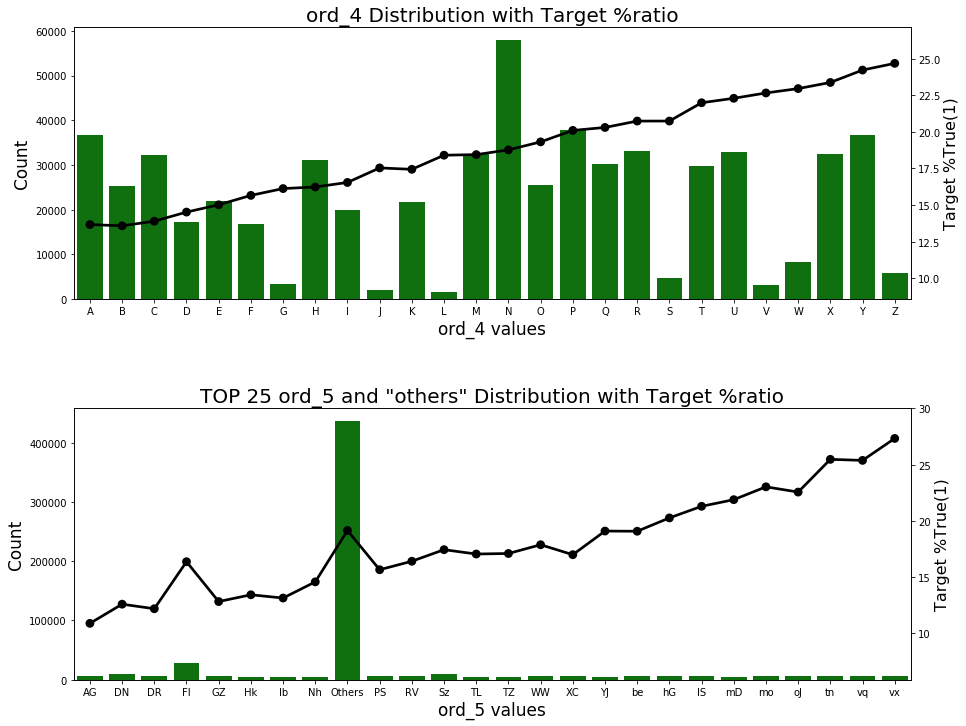

In [26]:
tmp = pd.crosstab(df['ord_4'], df['target'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)
plt.figure(figsize=(15,12))

plt.subplot(211)
ax = sns.countplot(x='ord_4', data=df, order=list(tmp['ord_4'].values) , color='green') 
ax.set_ylabel('Count', fontsize=17) # y axis label
ax.set_title('ord_4 Distribution with Target %ratio', fontsize=20) # title label
ax.set_xlabel('ord_4 values', fontsize=17) # x axis label
# twinX - to build a second yaxis
gt = ax.twinx()
gt = sns.pointplot(x='ord_4', y='Yes', data=tmp,
                   order=list(tmp['ord_4'].values),
                   color='black', legend=False)
gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
gt.set_ylabel("Target %True(1)", fontsize=16)

tmp = pd.crosstab(df['ord_5_ot'], df['target'], normalize='index') * 100
tmp = tmp.reset_index()
tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

plt.subplot(212)
ax1 = sns.countplot(x='ord_5_ot', data=df,
                   order=list(df['ord_5_ot'].value_counts().sort_index().index) ,
                   color='green') 
ax1.set_ylabel('Count', fontsize=17) # y axis label
ax1.set_title('TOP 25 ord_5 and "others" Distribution with Target %ratio', fontsize=20) # title label
ax1.set_xlabel('ord_5 values', fontsize=17) # x axis label
# twinX - to build a second yaxis
gt = ax1.twinx()
gt = sns.pointplot(x='ord_5_ot', y='Yes', data=tmp,
                   order=list(df['ord_5_ot'].value_counts().sort_index().index),
                   color='black', legend=False)
gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
gt.set_ylabel("Target %True(1)", fontsize=16)

plt.subplots_adjust(hspace = 0.4, wspace=.3)

plt.show()

Cool! <br> 
- In ord_4, as it is a ordinal feature, we can see a clearly linear relationship. As it is the alphabet order, it will be easy to encode
- In ord_5 we have many category's, the top category is:<br>
1 - "od" with 5019 entries, <br>
2 - "f0" with 3435 entries, <br>
3 - "Zq" with 2926<br>

### Features Transformation (Label encoding)

In [27]:
# Importing categorical options of pandas
from pandas.api.types import CategoricalDtype 

# seting the orders of our ordinal features
ord_1 = CategoricalDtype(categories=['Novice', 'Contributor','Expert', 
                                     'Master', 'Grandmaster'], ordered=True)
ord_2 = CategoricalDtype(categories=['Freezing', 'Cold', 'Warm', 'Hot',
                                     'Boiling Hot', 'Lava Hot'], ordered=True)
ord_3 = CategoricalDtype(categories=['a', 'b', 'c', 'd', 'e', 'f', 'g',
                                     'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o'], ordered=True)
ord_4 = CategoricalDtype(categories=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I',
                                     'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
                                     'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'], ordered=True)

In [28]:
# Transforming ordinal Features
df.ord_1 = df.ord_1.astype(ord_1)
df.ord_2 = df.ord_2.astype(ord_2)
df.ord_3 = df.ord_3.astype(ord_3)
df.ord_4 = df.ord_4.astype(ord_4)

In [29]:
df.ord_3.head()

0    c
1    e
2    n
3    a
4    h
Name: ord_3, dtype: category
Categories (15, object): [a < b < c < d ... l < m < n < o]

Ok, now it's ordered and we can get the codes that corresponds to each value in the nominal feature;

### Geting codes of nominal feature

In [30]:
# Geting the codes of ordinal categoy's - train
df.ord_1 = df.ord_1.cat.codes
df.ord_2 = df.ord_2.cat.codes
df.ord_3 = df.ord_3.cat.codes
df.ord_4 = df.ord_4.cat.codes

### Checking the results

In [31]:
df[['ord_0', 'ord_1', 'ord_2', 'ord_3']].head()

,ord_0,ord_1,ord_2,ord_3
0,3,1,3,2
1,3,4,2,4
2,3,0,0,13
3,1,0,5,0
4,3,4,1,7


<h1><font color='blue'>Cyclical Features</font></h1>

In [32]:
date_cols = ['day', 'month']

### Features before transformation

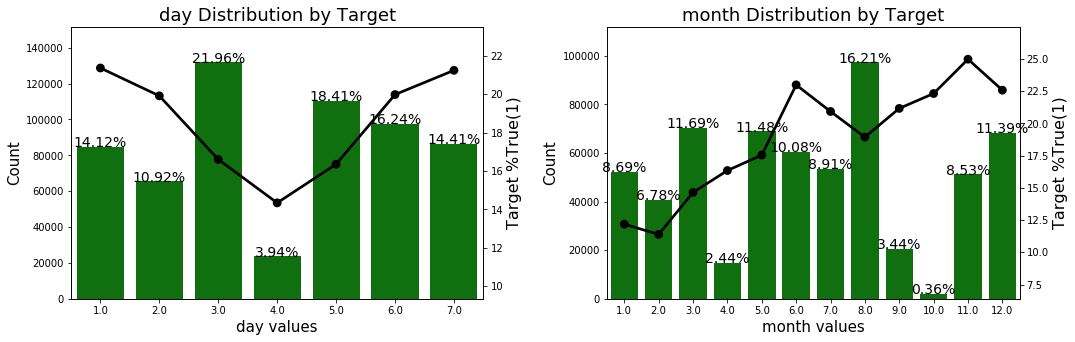

In [33]:
ploting_cat_fet(df, date_cols, vis_row=5, vis_col=2)

### Features Transformation (sin, cos encoding)

In [34]:
def date_cyc_enc(df, col, max_vals):
    df[col + '_sin'] = np.sin((2 * np.pi * df[col].values/max_vals).astype(float))
    df[col + '_cos'] = np.cos((2 * np.pi * df[col].values/max_vals).astype(float))
    return df

df = date_cyc_enc(df, 'day', 7)
df = date_cyc_enc(df, 'month', 12)

### Checking the results

In [35]:
df[['day_sin', 'day_cos', 'month_sin', 'month_cos']].head()

,day_sin,day_cos,month_sin,month_cos
0,-7.818315e-01,0.623490,1.000000e+00,6.123234e-17
1,-2.449294e-16,1.000000,-5.000000e-01,-8.660254e-01
2,-9.749279e-01,-0.222521,-1.000000e+00,-1.836970e-16
3,4.338837e-01,-0.900969,1.000000e+00,6.123234e-17
4,-9.749279e-01,-0.222521,-2.449294e-16,1.000000e+00


<div style="background-color:lightblue;">
    <center>
        <h3 style="color:red; font-size:24px; font-family:Segoe Print;">Start Training</h3>
    </center>
</div>

### Seting X and Y

In [36]:
df.bin_0 = df.bin_0.astype(bool)
df.bin_1 = df.bin_1.astype(bool)
df.bin_2 = df.bin_2.astype(bool)
df.ord_0 = df.ord_0.astype(int)

In [37]:
df = reduce_mem_usage(df)

Mem. usage decreased to 77.82 Mb (35.5% reduction)


In [38]:
summary = resumetable(df)
summary

Dataset Shape: (600000, 50)


,Name,dtypes,% of missing values,Uniques,First Value,Second Value
0,id,object,0.0,600000,0,1
1,bin_0,bool,0.0,2,False,True
2,bin_1,bool,0.0,2,False,True
3,bin_2,bool,0.0,2,False,False
4,bin_3,int8,0.0,2,0,0
5,bin_4,int8,0.0,2,0,1
6,nom_5,object,0.0,1220,de4c57ee2,2bb3c3e5c
7,nom_6,object,0.0,1519,a64bc7ddf,3a3a936e8
8,nom_7,object,0.0,222,598080a91,1dddb8473
9,nom_8,object,0.0,222,0256c7a4b,52ead350c


In [39]:
df.drop(['id','ord_5','ord_5_ot', 'day', 'month', 'nom_5', 'nom_6', 'nom_7', 'nom_8','nom_9'], axis=1, inplace=True)

In [40]:
X = df.drop('target', axis=1)
y = df['target'].astype(bool)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])

#Training data points: 480000
#Testing data points: 120000


## Libraries to Machine Learning Modeling

In [42]:
#Importing the auxiliar and preprocessing librarys 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

#Models
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

<h3>normalization</h3>

In [43]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

<h3>Decision Tree</h3>

In [44]:
# criterion : impurity function
# max_depth : maximum depth of tree
# random_state : seed of random number generator

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3, 
                              random_state=0)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
print('[Decision Tree]')
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[Decision Tree]
Accuracy: 0.8145


In [45]:
# C : regularization strength, 
#    big C : try to get 100% correct on training set -> slower
#    small C: tolerate some error estimation -> might have lower accuracy 
# solver : Algorithm to use in the optimization problem

lr = LogisticRegression(C = 1000.0, random_state = 0, solver = "liblinear")

lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
print('[Logistic Regression]')
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[Logistic Regression]
Accuracy: 0.8177


## Grid Search

<h3>Decision Tree</h3>

In [46]:
param_depth = [1, 2, 3, 4, 5]
param_criterion = ['gini', 'entropy']

tree = DecisionTreeClassifier(random_state=0)

# set the param_grid parameter of GridSearchCV to a list of dictionaries
param_grid = [{'max_depth': param_depth, 
               'criterion': param_criterion}]
               
gs_tree = GridSearchCV(estimator=tree, 
                  param_grid=param_grid, 
                  scoring='accuracy')

gs_tree = gs_tree.fit(X_train_std, y_train)
print(gs_tree.best_score_)
print(gs_tree.best_params_)

0.8123666666666667
{'criterion': 'gini', 'max_depth': 1}


In [47]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=1, 
                              random_state=0)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)
print('[Decision Tree]')
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[Decision Tree]
Accuracy: 0.8145


<h3>Logistic Regression</h3>

In [48]:
param_C = [0.001, 0.01, 0.1, 1, 10, 100]

lr = LogisticRegression(random_state = 0, solver = "liblinear")

# set the param_grid parameter of GridSearchCV to a list of dictionaries
param_grid = [{'C': param_C}]
               
gs_lr = GridSearchCV(estimator=lr, 
                  param_grid=param_grid, 
                  scoring='accuracy')

gs_lr = gs_lr.fit(X_train_std, y_train)
print(gs_lr.best_score_)
print(gs_lr.best_params_)

0.8155145833333334
{'C': 0.001}


In [49]:
lr = LogisticRegression(C = 0.001, random_state = 0, solver = "liblinear")

lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
print('[Logistic Regression]')
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))

[Logistic Regression]
Accuracy: 0.8176


## Confusion Matrix

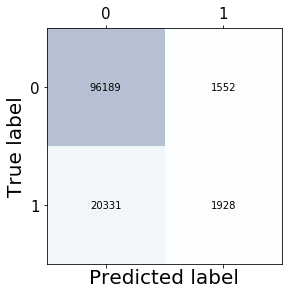

In [50]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(4,4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()

In [51]:
y_test.value_counts()

False    97741
True     22259
Name: target, dtype: int64

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
data = pd.read_csv("D://Blogs//train.csv")
X = data.iloc[:,0:20]  #independent columns
y = data.iloc[:,-1]    #target column i.e price range
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features